# MODULE 3
## Milestone 1: exploration phase

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use("ggplot")

In [2]:
box_builder_sample_data = '/home/unai/datasets/feature_frame.csv'
bb_df = pd.read_csv(box_builder_sample_data)
bb_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [3]:
bb_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [4]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [6]:
bb_df[categorical_cols].describe()

,product_type,vendor
count,2880549,2880549
unique,62,264
top,tinspackagedfoods,biona
freq,226474,146828


##### Categorical variables have very high cardinality. We are goning to use frequency encoding.

In [7]:
bb_df.product_type.replace(((bb_df['product_type'].value_counts()/len(bb_df)*100).round(5)).to_dict(), inplace=True)
bb_df.vendor.replace(((bb_df['vendor'].value_counts()/len(bb_df)*100).round(5)).to_dict(), inplace=True)

In [8]:
# We only keep orders with at least 5 items
orders = bb_df['order_id'].unique()
orders_more5 = orders[bb_df.groupby('order_id')['outcome'].sum() >= 5]
bb_df = bb_df.loc[bb_df['order_id'].isin(orders_more5)]

In [9]:
bb_df[label_col].value_counts()/len(bb_df)*100

outcome
0.0    98.552233
1.0     1.447767
Name: count, dtype: float64

##### Unbalanced problem --> We must mantain the porcentage in train, validation and testing datasets

In [10]:
# We avoid information leakage in train and test datasets of different users
users = bb_df['user_id'].unique()
users_train, users_validation, users_test = np.split(users, [int(.6 * len(users)), int(.78 * len(users))])

In [11]:
train = bb_df[bb_df['user_id'].isin(users_train)].reset_index()
X_train = train[features_cols]
Y_train = train[label_col]

validation = bb_df[bb_df['user_id'].isin(users_validation)].reset_index()
X_validation = validation[features_cols]
Y_validation = validation[label_col]

test = bb_df[bb_df['user_id'].isin(users_test)].reset_index()
X_test = test[features_cols]
Y_test = test[label_col]

In [12]:
print(f"Value counts train: {(Y_train.value_counts()/len(Y_train)*100).to_dict()}")
print(f"Value counts validation: {(Y_validation.value_counts()/len(Y_validation)*100).to_dict()}")
print(f"Value counts test: {(Y_test.value_counts()/len(Y_test)*100).to_dict()}")

Value counts train: {0.0: 98.48475974586931, 1.0: 1.5152402541306886}
Value counts validation: {0.0: 98.674001140962, 1.0: 1.3259988590379859}
Value counts test: {0.0: 98.73850229644577, 1.0: 1.2614977035542296}


##### We keep the balance in the training, validation and testing datasets

## TESTING DIFFERENT MODELS

In [14]:
from sklearn import linear_model
from sklearn import metrics

### LOGISTIC REGRESSION

In [15]:
regr = linear_model.LogisticRegression(penalty=None, max_iter=250, solver='sag')
regr.fit(X_train, Y_train)

/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=250, penalty=None, solver='sag')

In [16]:
betas = regr.coef_[0]

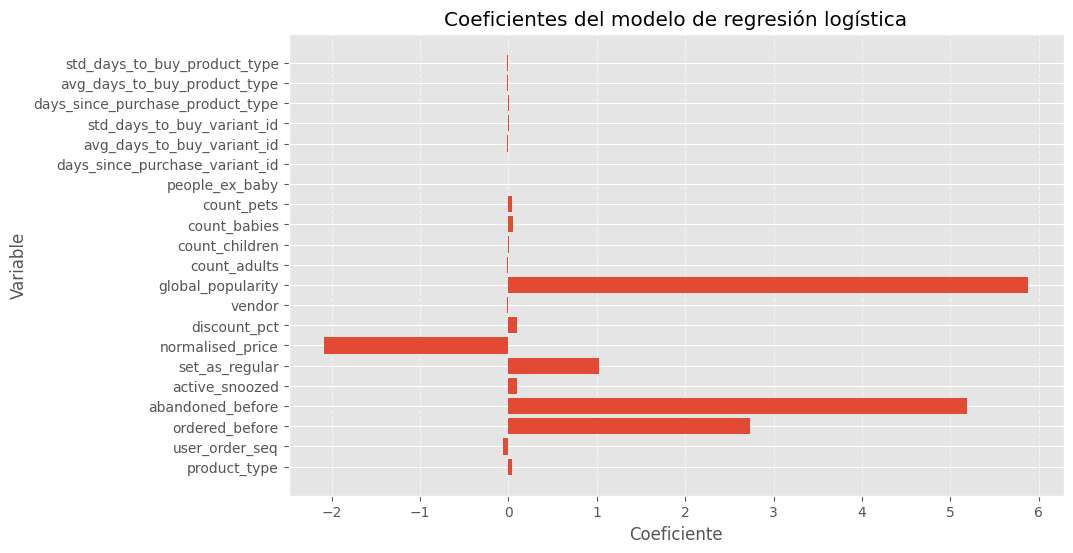

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(regr.feature_names_in_, betas)
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.title('Coeficientes del modelo de regresión logística')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### Dado que no hay diferencias de escalas considerables en las variables, en esta gráfica se puede observar la relevancia de cada una de las variables a la hora de predecir los resultados. Las variables más importantes son:
- Abandoned_before: Lógico porque si ese producto ha sido abandonado por el usuario, e sun factor que puede influir a la hora de comprarlo o no después.
- Ordered_before: Pasa lo mismo que con la anterior. Si ha sido comprado el item anteriormente, hay posibilidades de que lo vuelva a comprar.
- Normalised_price: El precio del producto es un factor importante a la hora de comprarlo o no. A mayor precio, menos probabilidad de compra. Por eso la relación es negativa.
- Set_as_regular: Si el usuario ha indicado que el producto como regular, quiere decir que comprará habitualmente, lo que aumenta las posibilidades de compra.
- Global_popularity: Un producto popular tiene más tendencia a ser comprado.

In [18]:
Y_prob = regr.predict_proba(X_validation)[:,1]

In [19]:
fpr, tpr, thresholds_roc = metrics.roc_curve(Y_validation, Y_prob)
auc_roc = metrics.roc_auc_score(Y_validation, Y_prob)

In [20]:
precision, recall, thresholds_precrec = metrics.precision_recall_curve(Y_validation, Y_prob)
auc_precrec = metrics.auc(recall, precision)

In [21]:
data = {'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds_roc}
roc = pd.DataFrame(data)

In [28]:
data = {'Precision': precision[0:len(precision) - 1], 'Recall': recall[0:len(recall) - 1], 'Threshold': thresholds_precrec}
precision_recall = pd.DataFrame(data)

Text(0.5, 1.0, 'Validation ROC curve')

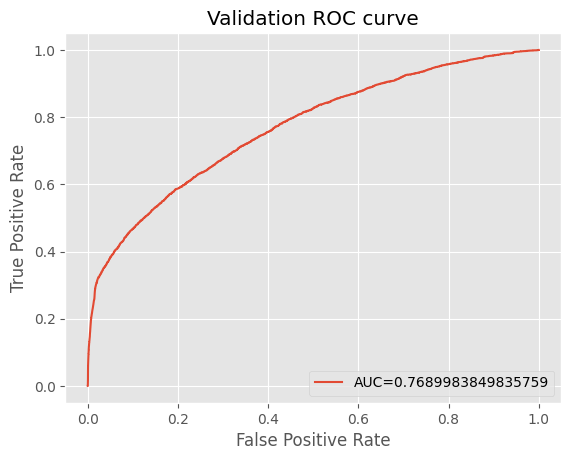

In [23]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc_roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Validation ROC curve")

Text(0.5, 1.0, 'Validation Precision-Recall curve')

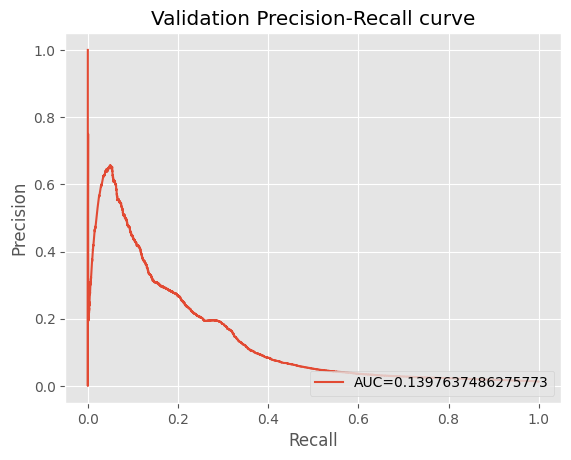

In [24]:
#create precision-recall-curve
plt.plot(recall, precision,label="AUC="+str(auc_precrec))
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc=4)
plt.title("Validation Precision-Recall curve")

- In this case, since the problem is so balanced with 99% of samples having a value of 0, the ROC curve does not give us as much information as the Precision-Recall.
- Based on this last curve, the goal is to work with the most precision and the most recall as posible. However, in this problem, I consider the recall to be the most important variable, since it is better to have more FP, which will only result in an unnecessary notification, than more FN, which will cause the company to lose possible user purchases.
- Although we could go to high recall values, we see that from 0.3 onwards, the precision drops a lot, which makes raising the recall pointless. Therefore, I think the interesting section of the curve is between 0.25 and 0.3 recall where the precision does not go down, and the recall goes up.

In [40]:
precision_recall[(precision_recall['Recall'] >= 0.25) & (precision_recall['Recall'] <= 0.28)]

,Precision,Recall,Threshold
124476,0.195608,0.279982,0.034658
124477,0.195483,0.279759,0.034661
124478,0.195513,0.279759,0.034665
124479,0.195388,0.279536,0.034676
124480,0.195418,0.279536,0.034682
...,...,...,...
125306,0.203741,0.250111,0.106037
125307,0.203778,0.250111,0.106074
125308,0.203815,0.250111,0.106130
125309,0.203852,0.250111,0.106169


#### FOR THE RECALL OF 0.28 AND PRECISION OF 0.19 IS THE BEST RATIO TO WORK IN THIS PROBLEM AS EXPLAIN BEFORE. THEN, THE THRESHOLD MUST BE AROUND 0.035

In [62]:
threshold = 0.035
Y_pred = np.zeros(Y_prob.shape)
Y_pred[Y_prob > threshold] = 1

In [72]:
C = metrics.confusion_matrix(Y_validation, Y_pred, normalize='true')
C[1,1]

0.27864467231386536

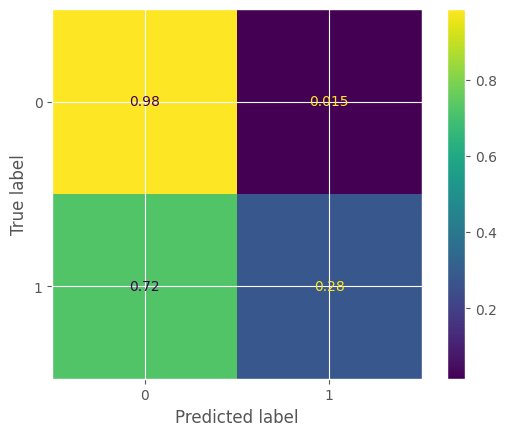

In [71]:
disp = metrics.ConfusionMatrixDisplay(C)
disp.plot()
plt.show()

##### WE OBTAIN TP/P = 0.28 (RECALL) AND TN/N = 0.98

### RIDGE

Probamos con diferentes coeficientes de regularización (alpha) para ver qué modelo obtiene una mejor tasa de recall (TP/P).

In [65]:
# Definir una lista de valores de C (inverso de alpha) que deseas probar
valores_C = [0.0001, 0.001, 0.01, 0.1, 1, 10]

In [73]:
resultados_ridge = []
threshold_ridge = 0.035
for alpha in valores_C:
    ridge = linear_model.LogisticRegression(penalty='l2', C = alpha, solver="sag", max_iter=250)
    ridge.fit(X_train, Y_train)
    Y_prob_ridge = ridge.predict_proba(X_validation)[:,1]
    Y_pred_ridge = np.zeros(Y_prob_ridge.shape)
    Y_pred_ridge[Y_prob_ridge > threshold_ridge] = 1
    C_ridge = metrics.confusion_matrix(Y_validation, Y_pred_ridge, normalize='true')
    resultado_actual = {'alpha': alpha, 'TP/P': C_ridge[1,1]}
    resultados_ridge.append(resultado_actual)

/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [140]:
resultados_ridge = pd.DataFrame(resultados_ridge)
alpha_opt_ridge = resultados_ridge.loc[resultados_ridge['TP/P'].idxmax()][0]

/tmp/ipykernel_1069/78468028.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_opt_ridge = resultados_ridge.loc[resultados_ridge['error_validacion'].idxmax()][0]


The optimal alpha for the ridge model is 1. Therefore, there are not many degrees of regularization, making the model very similar to the one obtained before without regularization.

In [141]:
ridge = linear_model.LogisticRegression(penalty='l2', C = alpha_opt_ridge, solver="sag", max_iter=250)
ridge.fit(X_train, Y_train)

/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=250, solver='sag')

In [143]:
betas_ridge = ridge.coef_[0]
betas_ridge

array([ 4.46210678e-02, -6.19541801e-02,  2.72900070e+00,  5.15920003e+00,
        9.90970574e-02,  1.02759095e+00, -2.07500838e+00,  1.00741445e-01,
       -1.47683303e-02,  5.82859169e+00, -1.13941938e-02,  8.48237615e-03,
        5.73509985e-02,  4.32036990e-02, -2.91181761e-03, -8.92674118e-03,
       -1.85270456e-02,  2.66160752e-03,  5.45363300e-03, -1.21417448e-02,
       -1.36232664e-02])

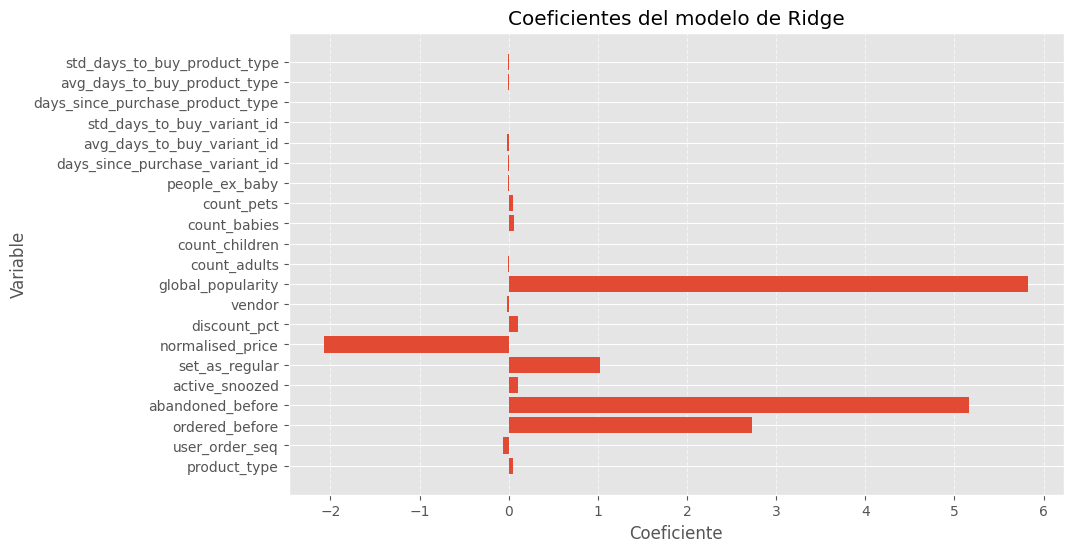

In [145]:
plt.figure(figsize=(10, 6))
plt.barh(ridge.feature_names_in_, betas_ridge)
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.title('Coeficientes del modelo de Ridge')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [164]:
Y_prob_ridge = ridge.predict_proba(X_validation)[:,1]

In [147]:
fpr_ridge, tpr_ridge, thresholds_roc_ridge = metrics.roc_curve(Y_validation, Y_prob_ridge)
auc_roc_ridge = metrics.roc_auc_score(Y_validation, Y_prob_ridge)

In [148]:
precision_ridge, recall_ridge, thresholds_precrec_ridge = metrics.precision_recall_curve(Y_validation, Y_prob_ridge)
auc_precrec_ridge = metrics.auc(recall_ridge, precision_ridge)

In [149]:
data = {'TPR': tpr_ridge, 'FPR': fpr_ridge, 'Threshold': thresholds_roc_ridge}
roc_ridge = pd.DataFrame(data)

In [150]:
data = {'Precision': precision_ridge[0:len(precision_ridge) - 1], 'Recall': recall_ridge[0:len(recall_ridge) - 1], 'Threshold': thresholds_precrec_ridge}
precision_recall_ridge= pd.DataFrame(data)

Text(0.5, 1.0, 'Validation ROC curve RIDGE')

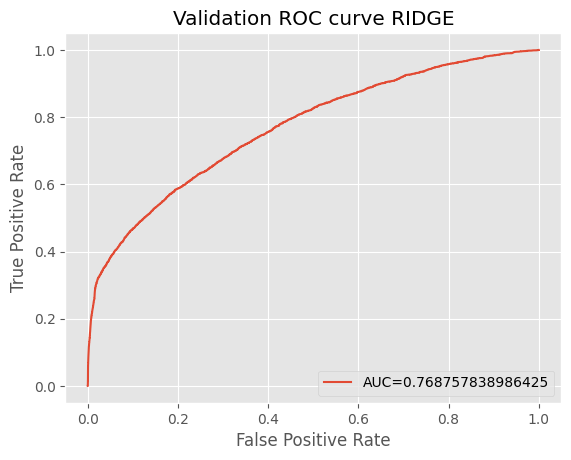

In [153]:
plt.plot(fpr_ridge,tpr_ridge,label="AUC="+str(auc_roc_ridge))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Validation ROC curve RIDGE")

Text(0.5, 1.0, 'Validation Precision-Recall curve RIDGE')

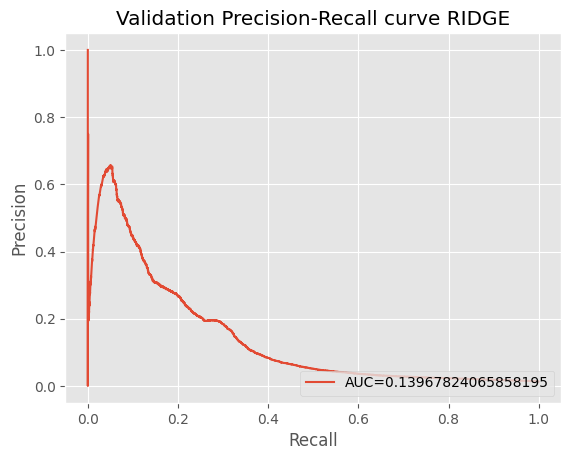

In [155]:
plt.plot(recall_ridge, precision_ridge,label="AUC="+str(auc_precrec_ridge))
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc=4)
plt.title("Validation Precision-Recall curve RIDGE")

In [166]:
threshold_ridge = 0.035
Y_pred_ridge = np.zeros(Y_prob_ridge.shape)
Y_pred_ridge[Y_prob_ridge > threshold_ridge] = 1

In [167]:
C_ridge = metrics.confusion_matrix(Y_validation, Y_pred_ridge, normalize='true')

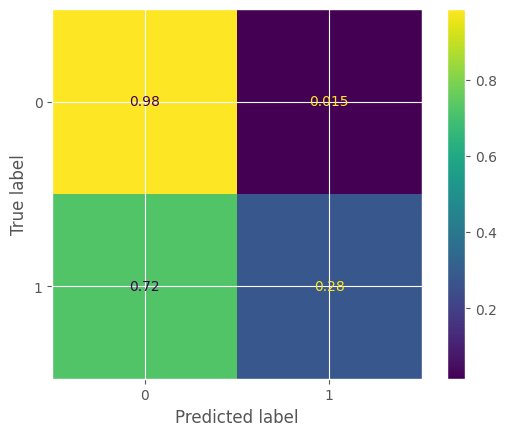

In [168]:
disp = metrics.ConfusionMatrixDisplay(C_ridge)
disp.plot()
plt.show()

## LASSO

In [118]:
resultados_lasso = []
threshold_lasso = 0.035
for alpha in valores_C:
    lasso = linear_model.LogisticRegression(penalty='l1', C = alpha, solver="saga", max_iter=250)
    lasso.fit(X_train, Y_train)
    Y_prob_lasso = lasso.predict_proba(X_validation)[:,1]
    Y_pred_lasso = np.zeros(Y_prob_lasso.shape)
    Y_pred_lasso[Y_prob_lasso > threshold_lasso] = 1
    C_lasso = metrics.confusion_matrix(Y_validation, Y_pred_lasso, normalize='true')
    resultado_actual = {'alpha': alpha, 'TP/P': C_lasso[1,1]}
    resultados_lasso.append(resultado_actual)

/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [121]:
resultados_lasso = pd.DataFrame(resultados_lasso)
alpha_opt_lasso = resultados_lasso.loc[resultados_lasso['TP/P'].idxmax()][0]

/tmp/ipykernel_1069/3035551485.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_opt_lasso = resultados_lasso.loc[resultados_lasso['TP/P'].idxmax()][0]


10.0

The alpha obtained is 0.1 (1/10). Since it is very close to 0, the model does not need regularization to obtain better results. This indicates that there is no overfitting in this case, and that a more flexible model obtains better results. This is logical in this problem, given the large size of the dataset, which allows greater degrees of freedom without the need for regularization.

In [122]:
lasso = linear_model.LogisticRegression(penalty='l1', C = alpha_opt_lasso, solver="saga", max_iter=250)
lasso.fit(X_train, Y_train)

/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10.0, max_iter=250, penalty='l1', solver='saga')

In [142]:
betas_lasso = lasso.coef_[0]
betas_lasso

array([ 4.15747072e-02, -6.54793469e-02,  2.77377533e+00,  4.64633651e+00,
        1.16644277e-01,  1.04644887e+00, -1.91775330e+00,  1.16122621e-01,
       -1.65704425e-02,  3.19529863e+00, -7.04879449e-02,  3.83311406e-02,
        5.51643745e-02,  4.88048567e-02, -3.11365102e-02, -9.83588045e-03,
       -1.89633432e-02,  1.96750063e-03,  5.35634278e-03, -1.54293508e-02,
       -2.22350711e-02])

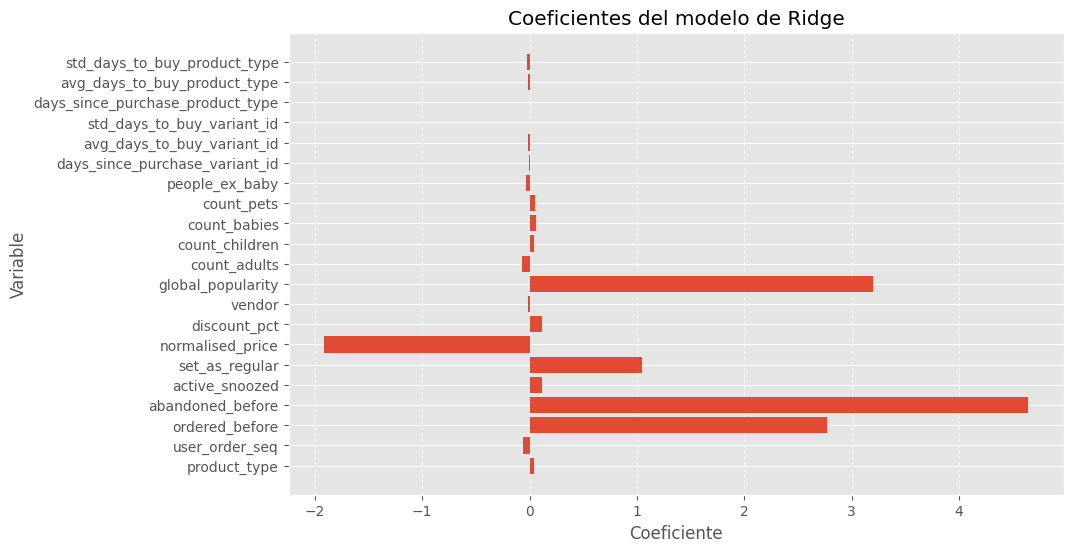

In [144]:
plt.figure(figsize=(10, 6))
plt.barh(lasso.feature_names_in_, betas_lasso)
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.title('Coeficientes del modelo de Lasso')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [125]:
Y_prob_lasso = lasso.predict_proba(X_validation)[:,1]

In [126]:
fpr_lasso, tpr_lasso, thresholds_roc_lasso = metrics.roc_curve(Y_validation, Y_prob_lasso)
auc_roc_lasso = metrics.roc_auc_score(Y_validation, Y_prob_lasso)

In [127]:
precision_lasso, recall_lasso, thresholds_precrec_lasso = metrics.precision_recall_curve(Y_validation, Y_prob_lasso)
auc_precrec_lasso = metrics.auc(recall_lasso, precision_lasso)

In [128]:
data = {'TPR': tpr_lasso, 'FPR': fpr_lasso, 'Threshold': thresholds_roc_lasso}
roc_lasso = pd.DataFrame(data)

In [129]:
data = {'Precision': precision_lasso[0:len(precision_lasso) - 1], 'Recall': recall_lasso[0:len(recall_lasso) - 1], 'Threshold': thresholds_precrec_lasso}
precision_recall_lasso = pd.DataFrame(data)

Text(0.5, 1.0, 'Validation ROC curve LASSO')

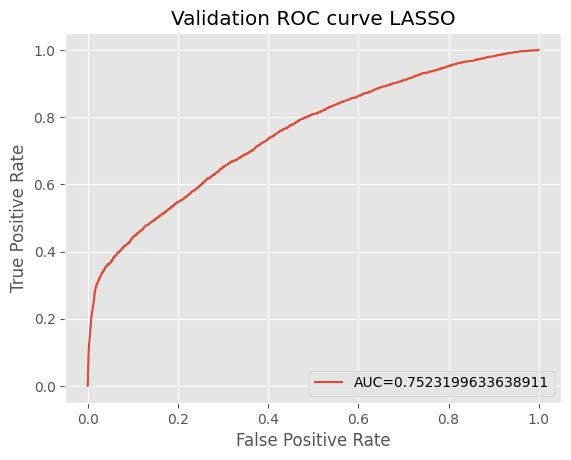

In [151]:
plt.plot(fpr_lasso,tpr_lasso,label="AUC="+str(auc_roc_lasso))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Validation ROC curve LASSO")

Text(0.5, 1.0, 'Validation Precision-Recall curve LASSO')

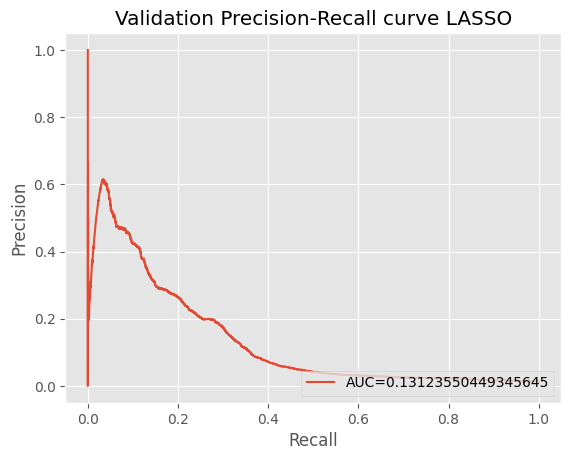

In [156]:
plt.plot(recall_lasso, precision_lasso,label="AUC="+str(auc_precrec_lasso))
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc=4)
plt.title("Validation Precision-Recall curve LASSO")

In [132]:
threshold_lasso = 0.035
Y_pred_lasso = np.zeros(Y_prob_lasso.shape)
Y_pred_lasso[Y_prob_lasso > threshold_lasso] = 1

In [133]:
C_lasso = metrics.confusion_matrix(Y_validation, Y_pred_lasso, normalize='true')

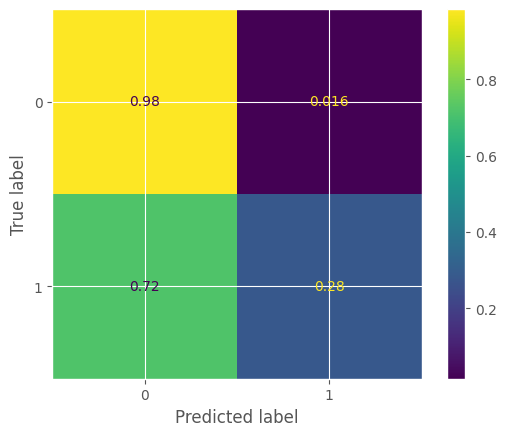

In [134]:
disp = metrics.ConfusionMatrixDisplay(C_lasso)
disp.plot()
plt.show()

### INSIGHTS:
- The results are very similar in the 3 models. The recall obtained is of 0.28 which means that out of all positives the model will predict 28% of them. This is a boost of 28% over
the selected items, which was one of the targets of the problem.
- Since the dataset is large, the regularization doesn't affect, because the overfitting is not a real problem.
- However, I think is better to choose the lasso, because there are a few variables (explained before) that have impact over the prediction. Because of that, and since the lasso model gets rid of some variables getting their betas to 0, the model will be lighter and will have less computational load